## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

## Exploring Dataset

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


<AxesSubplot:>

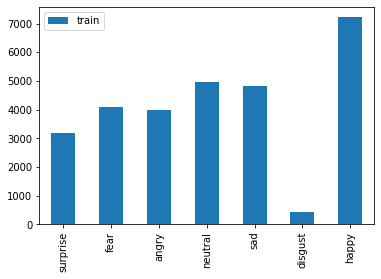

In [3]:
train_count.transpose().plot(kind='bar')

<AxesSubplot:>

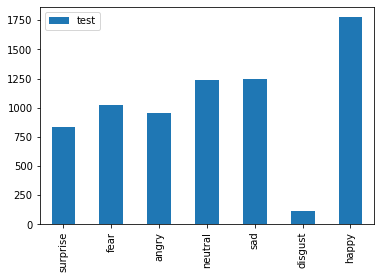

In [4]:
test_count.transpose().plot(kind='bar')

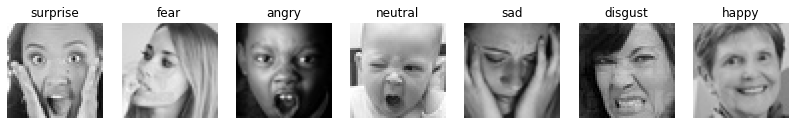

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating train test and validation datasets

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
validation_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# labels 
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Model Architecture

In [8]:
weight_decay = 1e-4

num_classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1088      
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        65600     
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0

2022-02-11 10:53:38.090897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 10:53:38.215879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 10:53:38.216645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 10:53:38.217794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

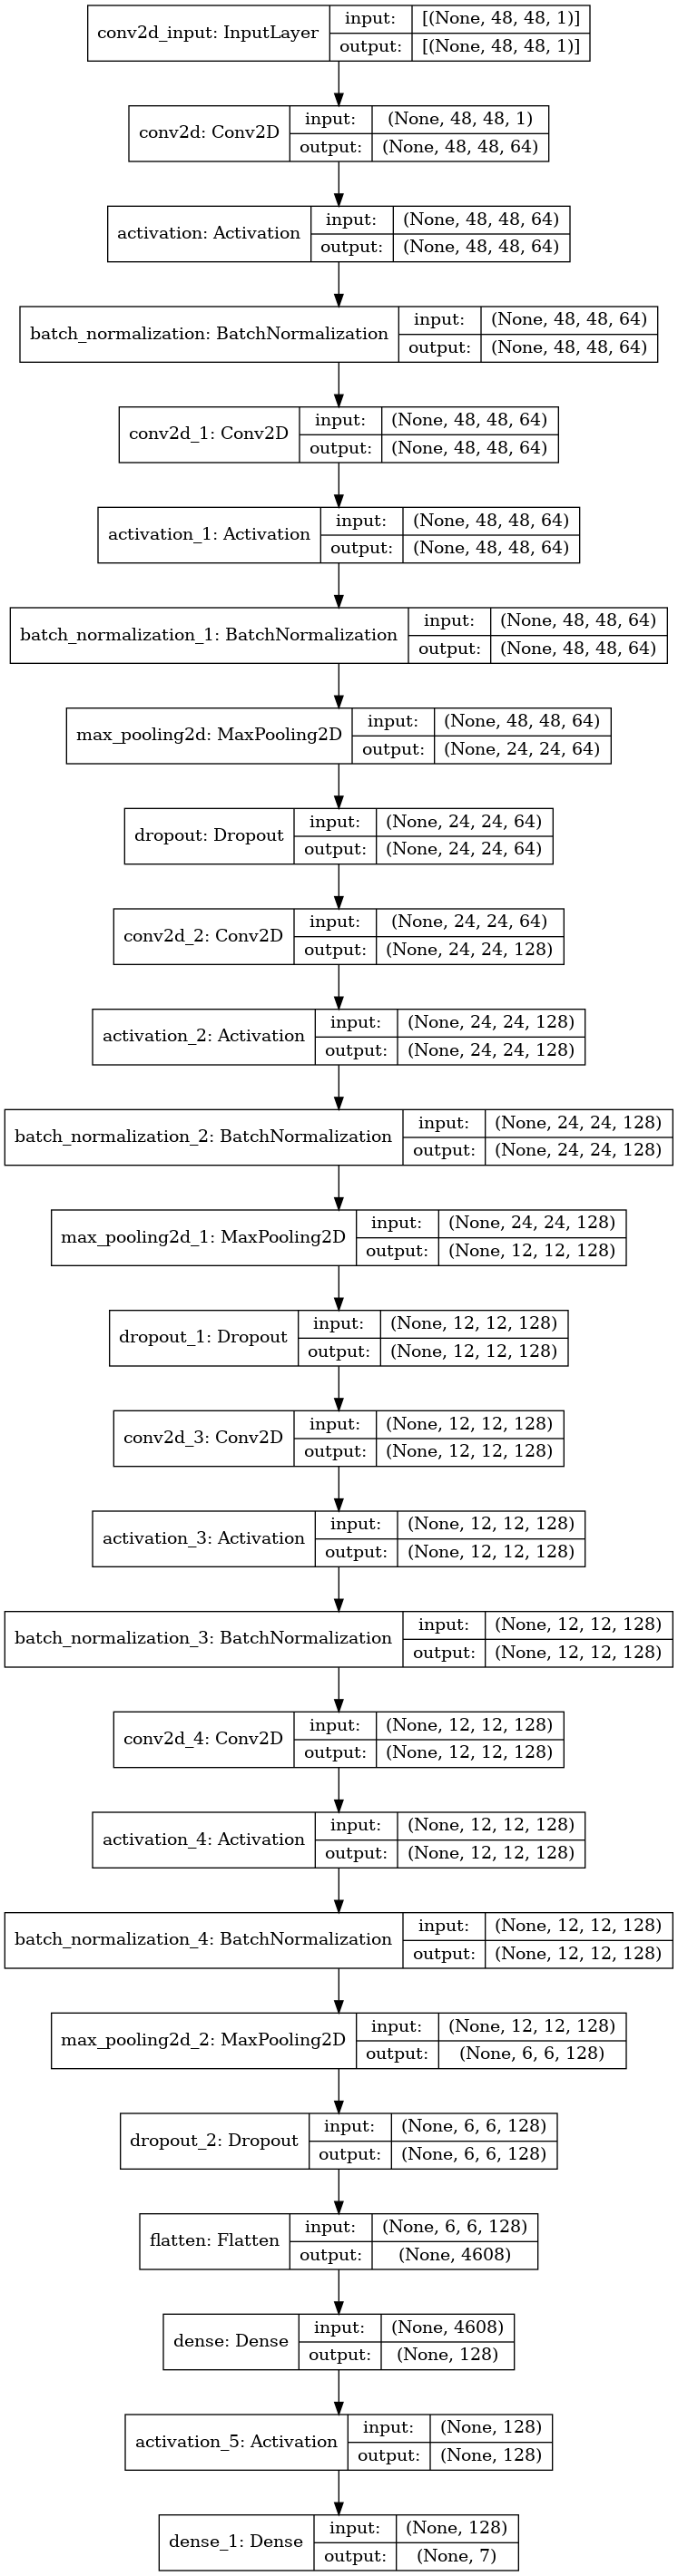

In [9]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

## Model Training

In [11]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=200,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

2022-02-11 10:53:42.118035: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-02-11 10:53:44.031246: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


358/358 [==============================] - 111s 290ms/step - loss: 1.8314 - accuracy: 0.3257 - val_loss: 1.8711 - val_accuracy: 0.2960

Epoch 00001: val_accuracy improved from -inf to 0.29600, saving model to model.weights.best.hdf5
Epoch 2/200
358/358 [==============================] - 22s 61ms/step - loss: 1.5477 - accuracy: 0.4181 - val_loss: 1.4463 - val_accuracy: 0.4610

Epoch 00002: val_accuracy improved from 0.29600 to 0.46103, saving model to model.weights.best.hdf5
Epoch 3/200
358/358 [==============================] - 23s 63ms/step - loss: 1.4282 - accuracy: 0.4686 - val_loss: 1.4074 - val_accuracy: 0.4816

Epoch 00003: val_accuracy improved from 0.46103 to 0.48157, saving model to model.weights.best.hdf5
Epoch 4/200
358/358 [==============================] - 22s 62ms/step - loss: 1.3466 - accuracy: 0.5033 - val_loss: 1.3453 - val_accuracy: 0.5009

Epoch 00004: val_accuracy improved from 0.48157 to 0.50088, saving model to model.weights.best.hdf5
Epoch 5/200
358/358 [========

## Model Performance

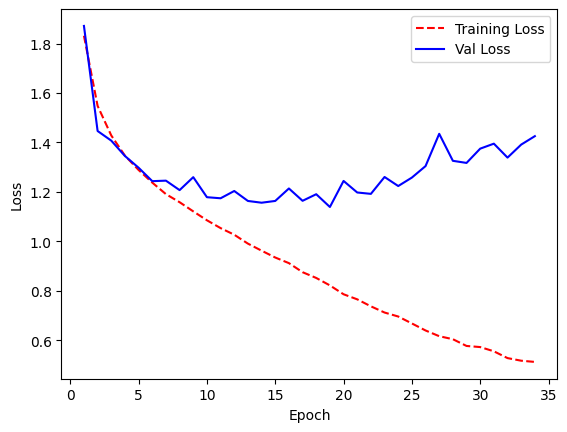

In [12]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

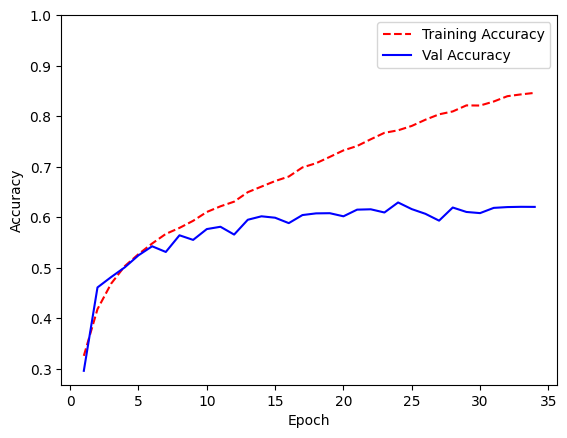

In [13]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [14]:
# saving the model
model.save("fer_model.h5")

## Test Accuracy

In [15]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

112/112 [==============================] - 31s 282ms/step - loss: 1.2172 - accuracy: 0.6320
Test accuracy = 63.19754719734192%


## Confusion Matrix

### Confusion matrix on Training Set

Confusion Matrix
[[ 416   56  279  855  589  613  388]
 [  47    5   41   96   65   59   36]
 [ 452   57  336  869  585  613  366]
 [ 782   93  557 1453 1133 1070  684]
 [ 543   64  376 1033  774  745  437]
 [ 468   70  364 1045  730  711  476]
 [ 334   45  244  671  471  444  328]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.13      3196
     disgust       0.01      0.01      0.01       349
        fear       0.15      0.10      0.12      3278
       happy       0.24      0.25      0.25      5772
     neutral       0.18      0.19      0.19      3972
         sad       0.17      0.18      0.18      3864
    surprise       0.12      0.13      0.12      2537

    accuracy                           0.18     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.18      0.17     22968



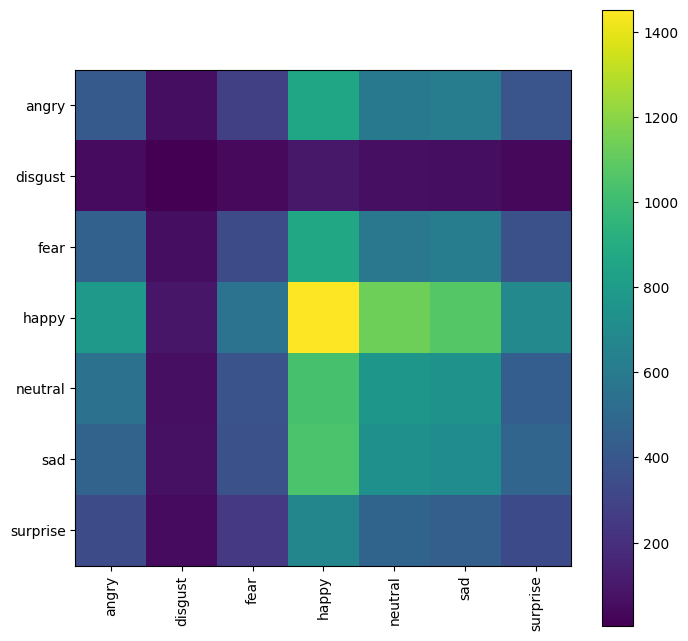

In [16]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix on Validation Dataset

Confusion Matrix
[[105  10  58 228 167 132  99]
 [ 16   5   7  18  17  15   9]
 [ 86  13  66 234 145 168 107]
 [169  26 102 417 288 294 147]
 [141  22  69 241 206 212 102]
 [135  15  78 257 180 190 111]
 [ 85   6  46 168 137 116  76]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.14       799
     disgust       0.05      0.06      0.05        87
        fear       0.15      0.08      0.11       819
       happy       0.27      0.29      0.28      1443
     neutral       0.18      0.21      0.19       993
         sad       0.17      0.20      0.18       966
    surprise       0.12      0.12      0.12       634

    accuracy                           0.19      5741
   macro avg       0.15      0.15      0.15      5741
weighted avg       0.18      0.19      0.18      5741



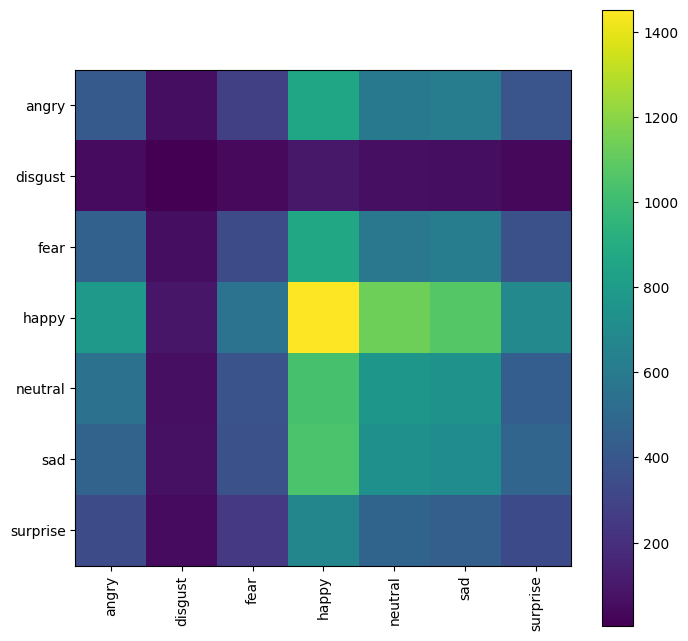

In [17]:
y_pred = model.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)
cm_val = confusion_matrix(validation_set.classes, y_pred)
print('Confusion Matrix')
print(cm_val)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Confusion Matrix on Test Dataset

Confusion Matrix
[[124  17  78 243 176 203 117]
 [ 13   2   5  27  31  21  12]
 [137  14  67 266 189 205 146]
 [221  25 132 483 372 346 195]
 [159  23 100 325 259 232 135]
 [161  24  80 330 240 253 159]
 [104  19  63 199 180 157 109]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       958
     disgust       0.02      0.02      0.02       111
        fear       0.13      0.07      0.09      1024
       happy       0.26      0.27      0.26      1774
     neutral       0.18      0.21      0.19      1233
         sad       0.18      0.20      0.19      1247
    surprise       0.12      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.18      0.18      7178



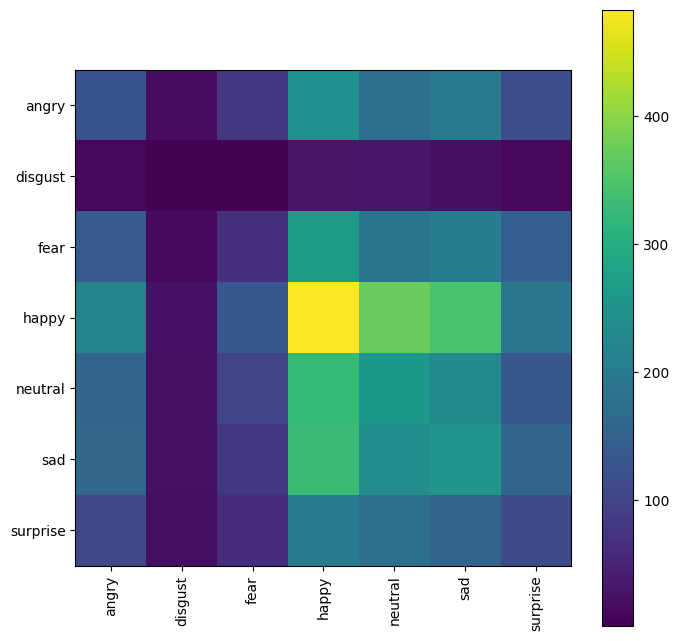

In [18]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Plotting Predictions

In [19]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)

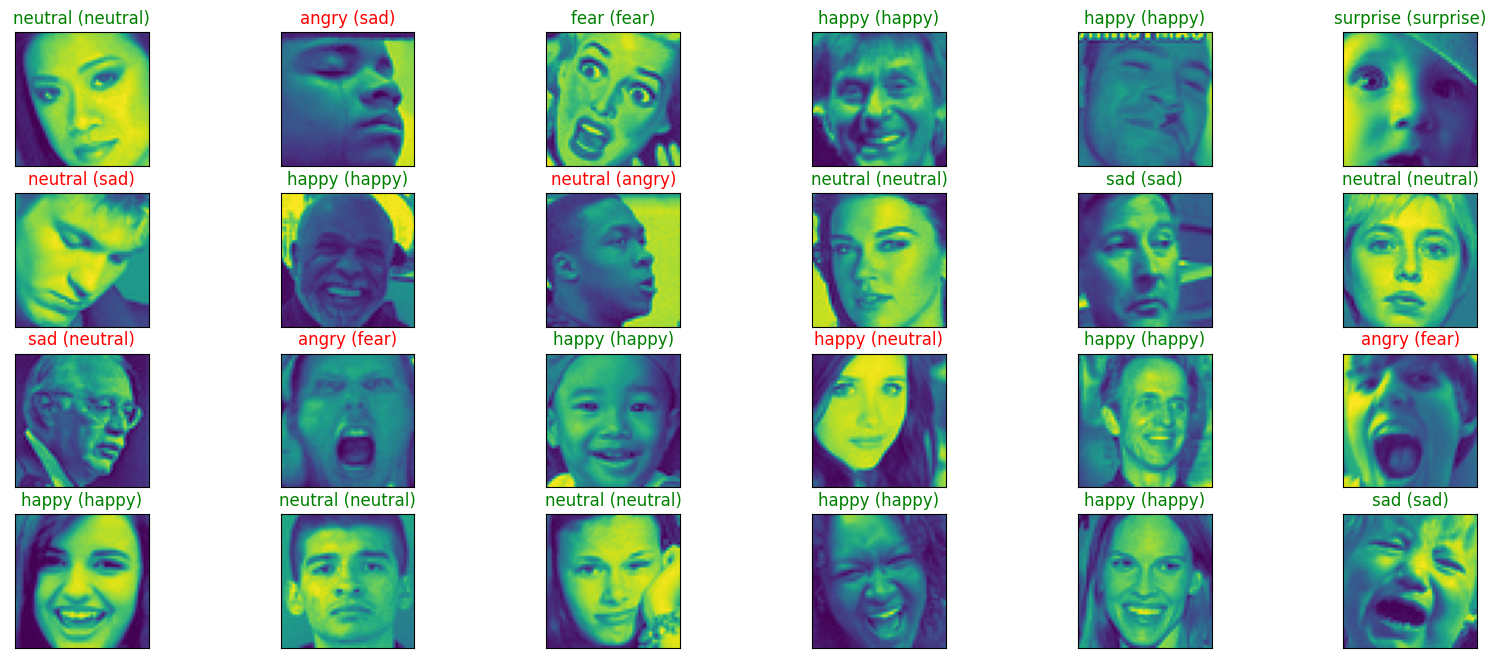

In [20]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))